In [42]:
import pandas as pd
from quickda.clean_data import clean
from quickda.explore_numeric import eda_num
from quickda.explore_categoric import eda_cat
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

# Importe y Limpieza

In [35]:
importes = pd.read_csv('importes.csv', encoding='latin-1')
consumos = pd.read_csv('consumos.csv', encoding='latin-1')
precios = pd.read_csv('precios.csv', encoding='latin-1')

importes.name, consumos.name, precios.name = "Importes", "Consumos", "Precios"

dataframes = [importes, consumos, precios]

def info_df(describe = False):
    for df in dataframes:
        print(df.head())
        print(df.describe() if describe else "")

# Separar mes y año

importes[['Mes', 'Año']] = importes['Fecha'].str.split('-', expand=True)
consumos[['Mes', 'Año']] = consumos['Fecha'].str.split('-', expand=True)
precios[['Dia','Mes', 'Año']] = precios['Fecha'].str.split('-', expand=True)

for x in dataframes:
    x = clean(x, 'duplicates')
    x = clean(x, 'standarize')

# Analisis Exploratorio

---------------------Importes---------------------


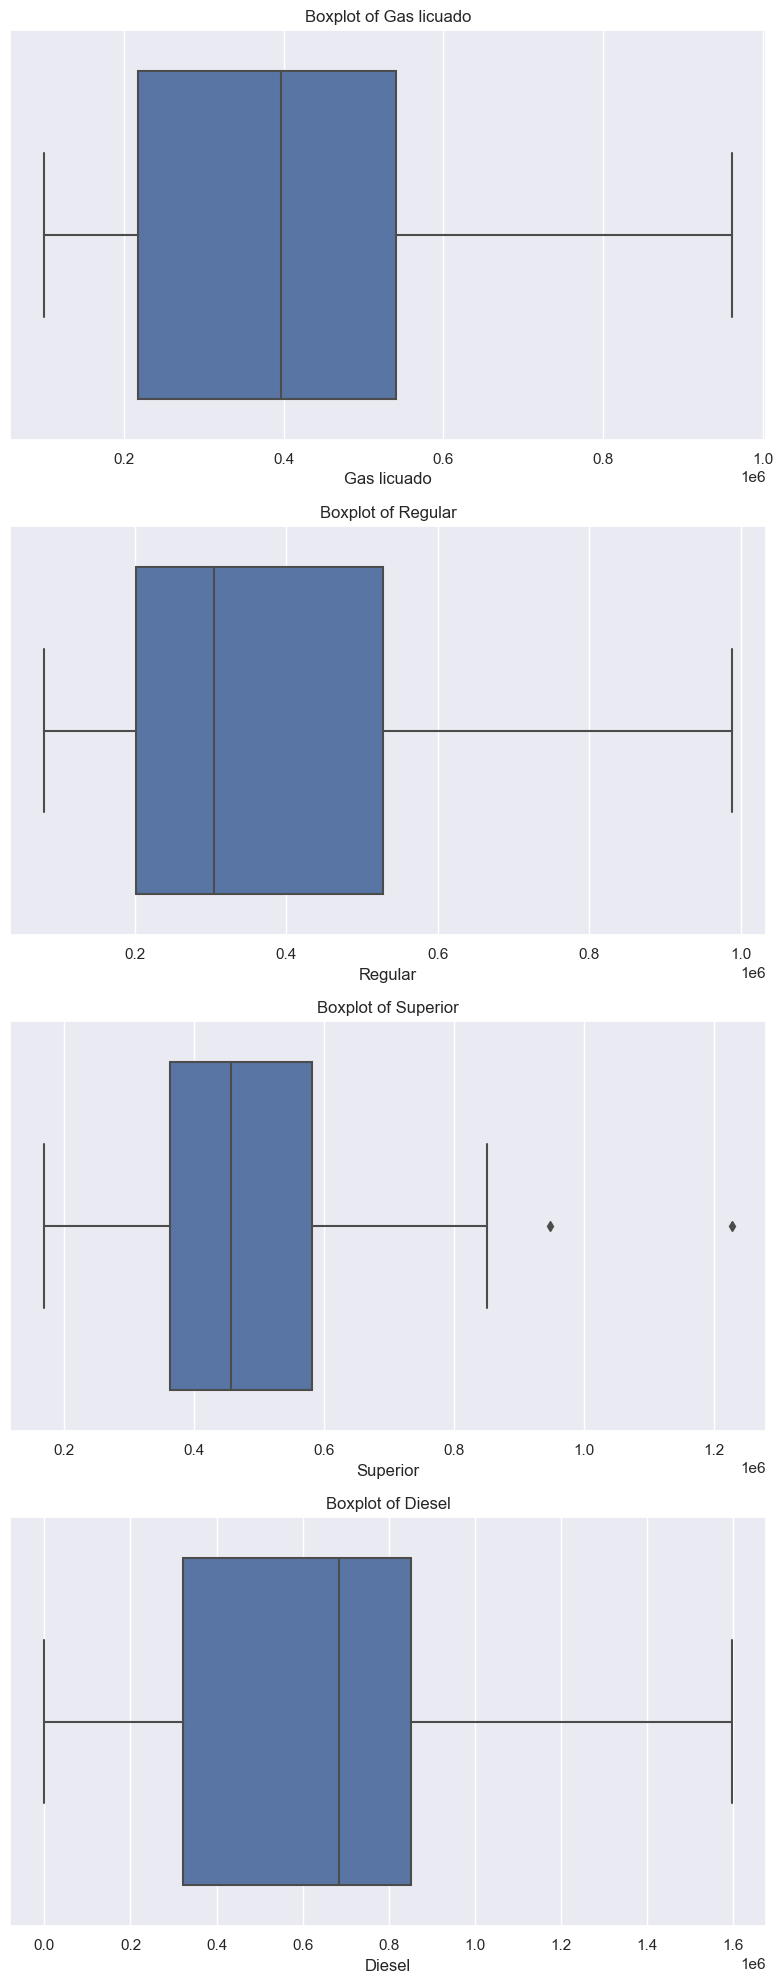

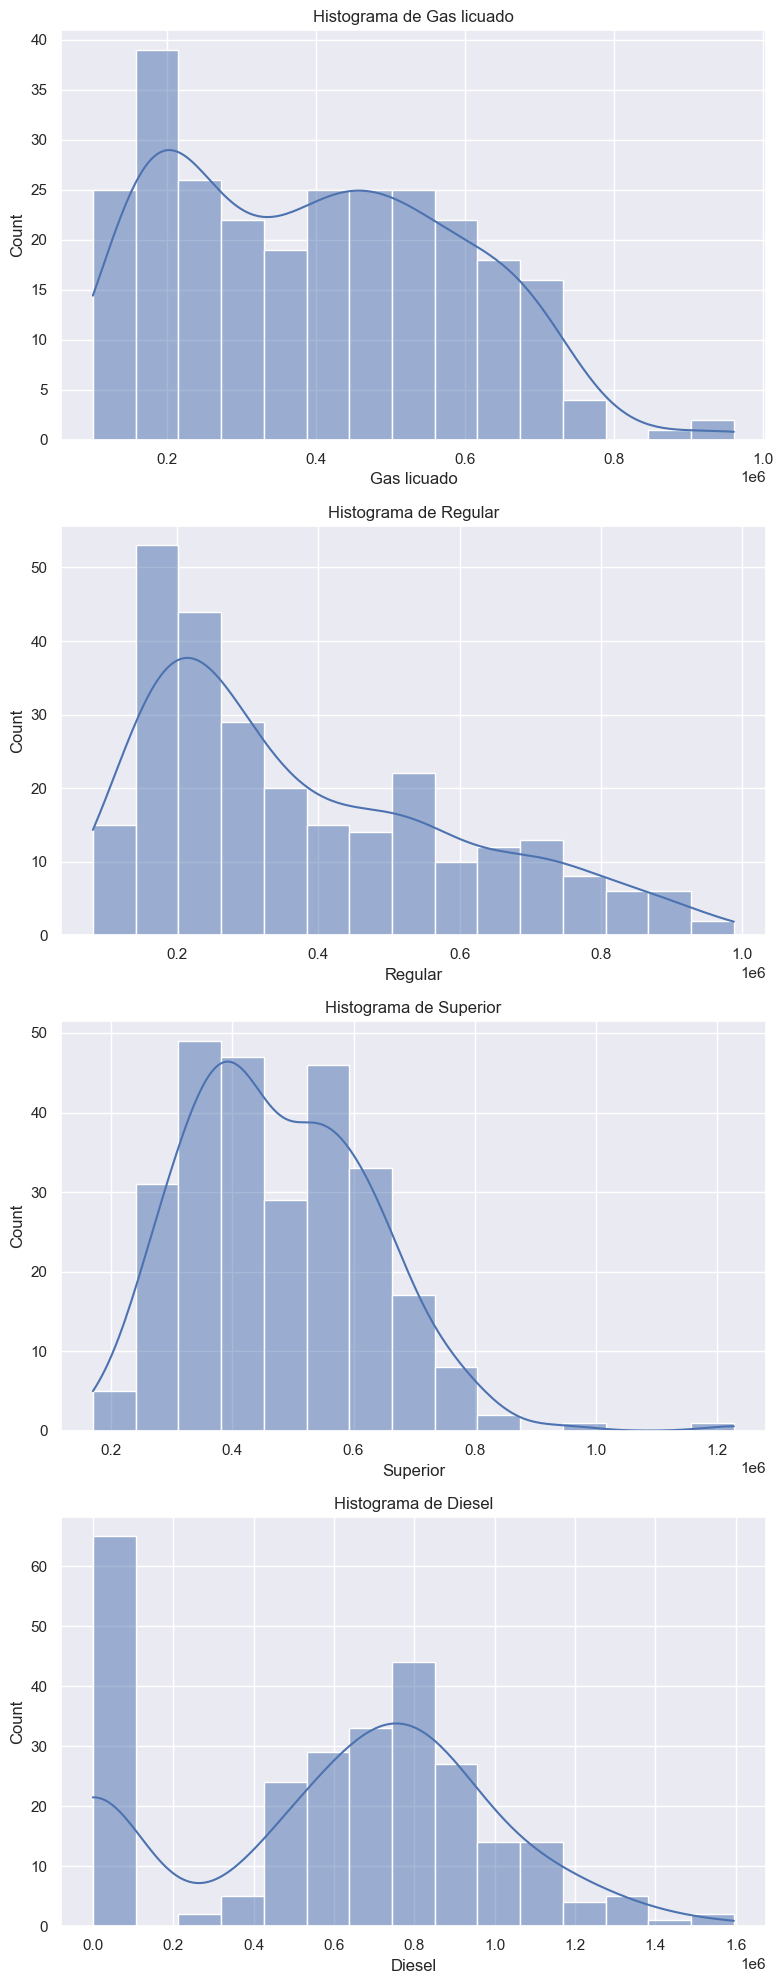

---------------------Consumos---------------------


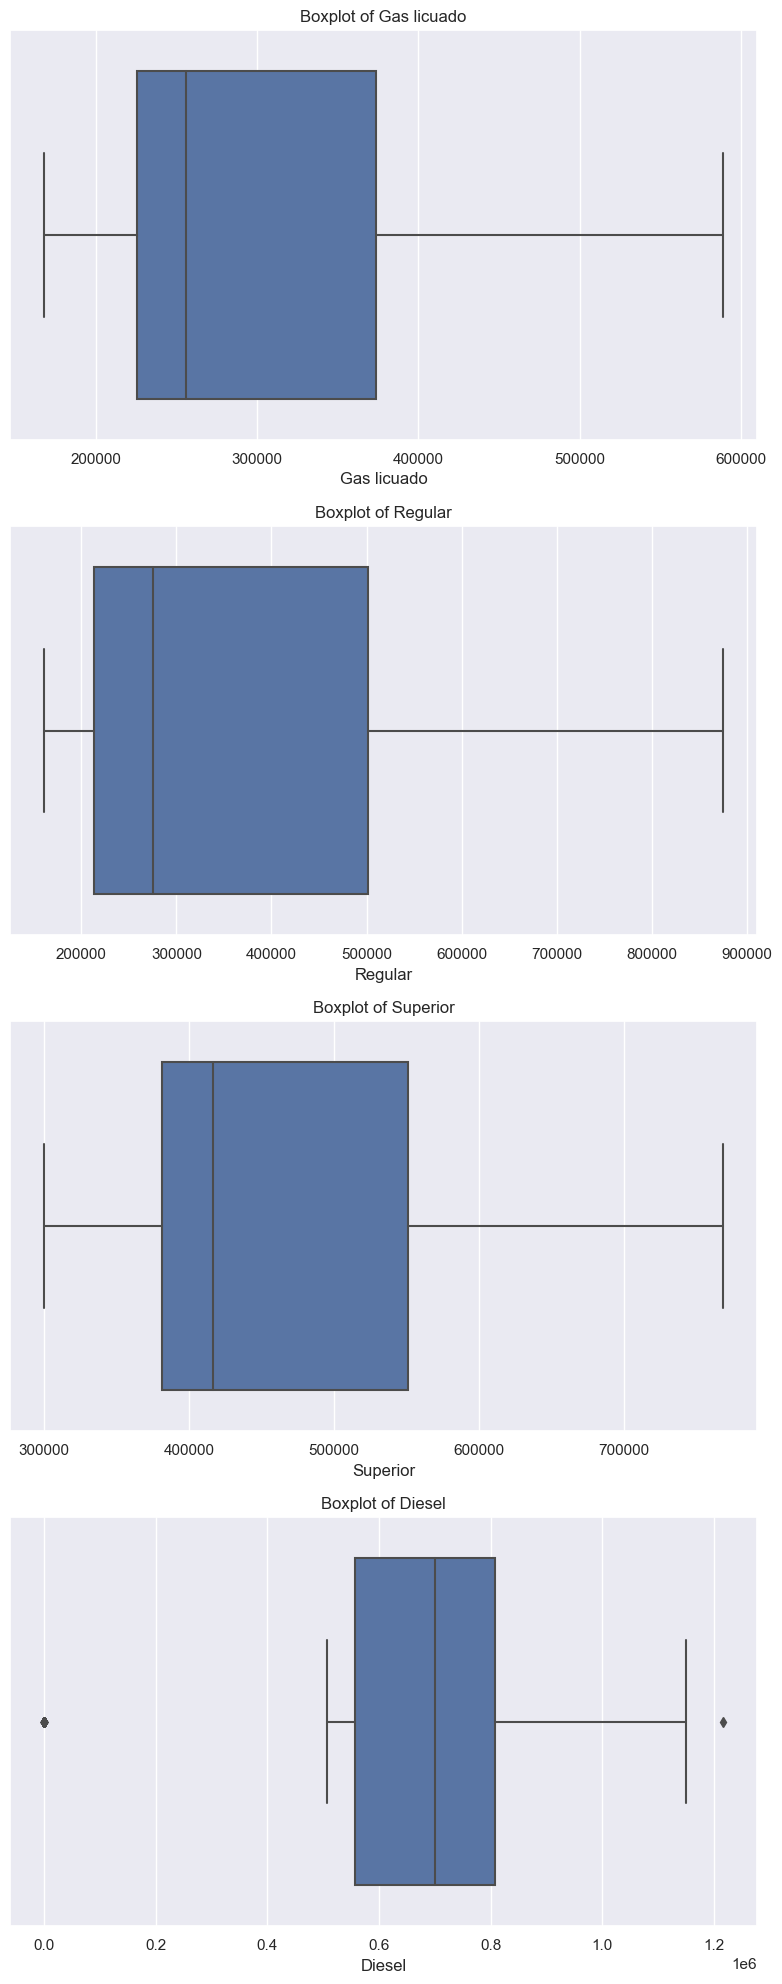

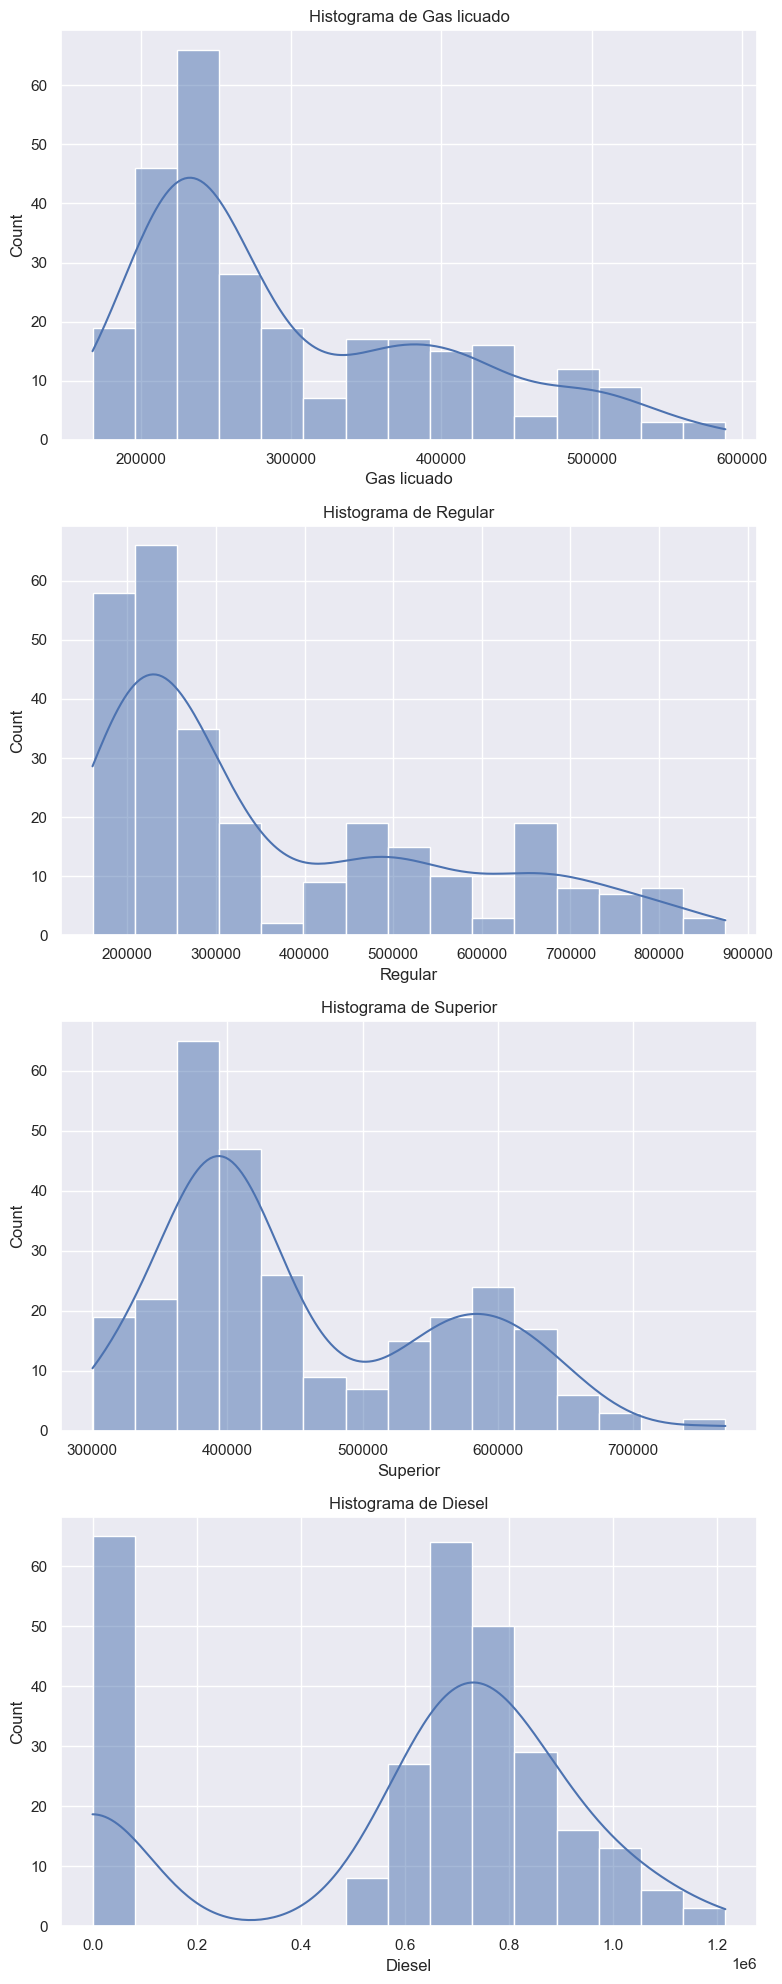

---------------------Precios----------------------


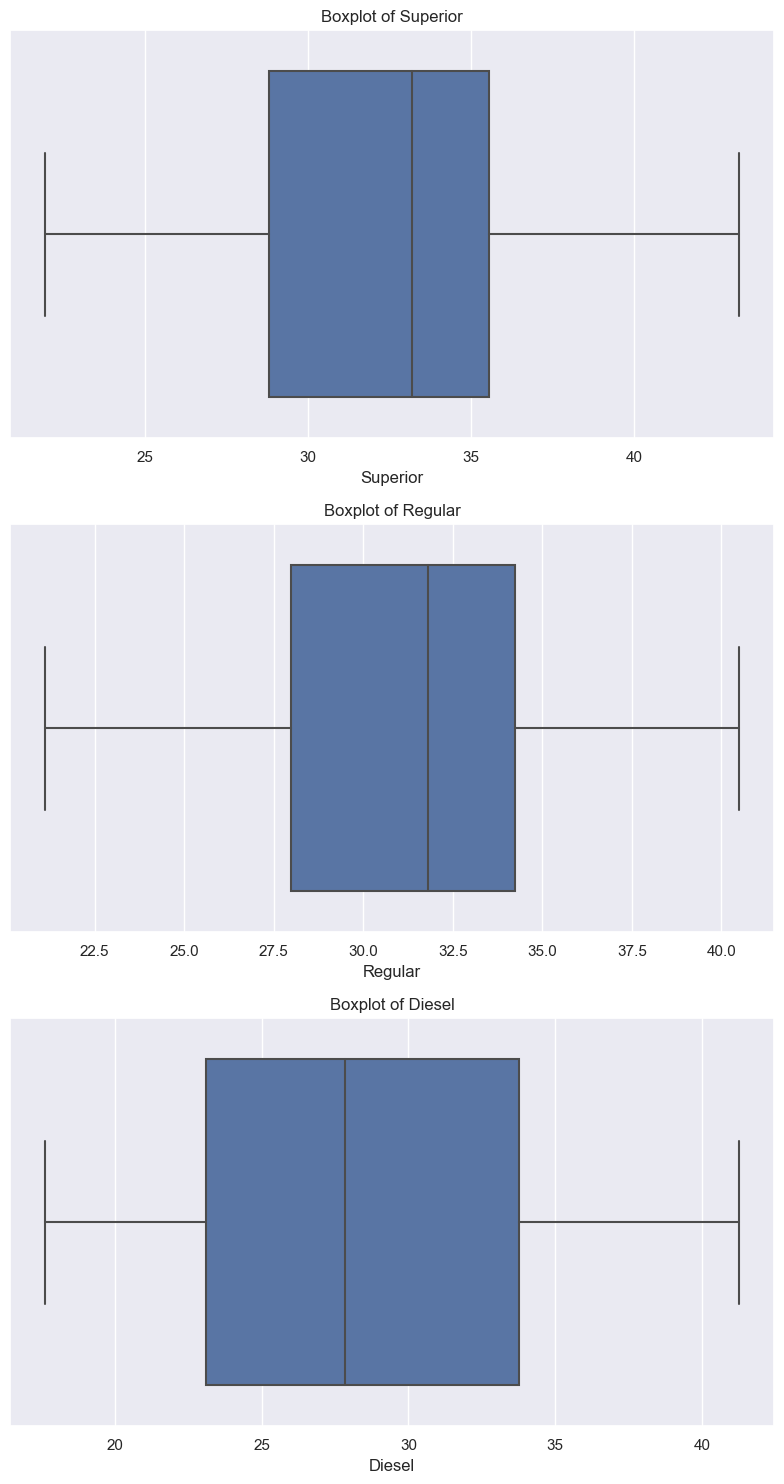

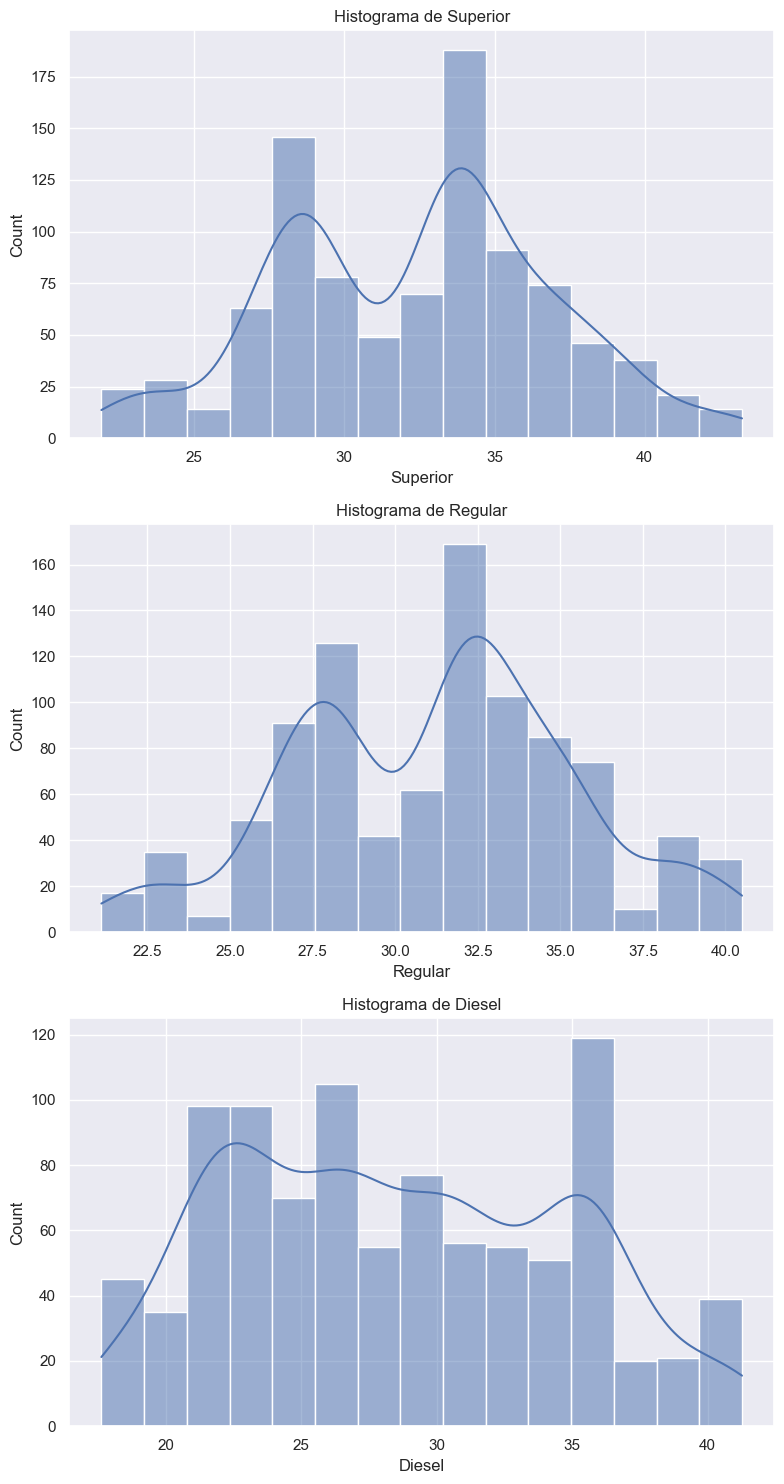

In [56]:
   
def get_numeric_columns(dataframe: pd.DataFrame) -> list[str]:
    """Gets the names of all numeric columns in the dataframe.

    Args:
        dataframe (pd.Dataframe): A pandas DataFrame.

    Returns:
        List<str>: List of column names that are numeric.
    """
    
    return dataframe.select_dtypes(include=['number']).columns.tolist()

def get_categorical_columns(dataframe):
    """Gets the names of all categoric columns in the dataframe.

    Args:
        dataframe (pd.Dataframe): A pandas DataFrame.

    Returns:
        List<str>: List of column names that are categoric.
    """
    return dataframe.select_dtypes(include=['object']).columns.tolist()

def exploration(dataframe: pd.DataFrame, categorical = False) -> None:
    
    numeric = get_numeric_columns(dataframe)
    n_num = len(numeric)
    
    _, axes = plt.subplots(n_num, 1, figsize=(8, 5 * n_num)) 
    
    for var, ax in zip(numeric, axes):
        sns.boxplot(x=dataframe[var], ax=ax)
        ax.set_title('Boxplot of ' + var)

    plt.tight_layout()
    
    _, axes = plt.subplots(n_num, 1, figsize=(8, 5 * n_num))
    
    for var, ax in zip(numeric, axes):
        sns.histplot(dataframe[var], kde=True, ax=ax, bins=15)
        ax.set_title('Histograma de ' + var)
        
    plt.tight_layout()
    
    plt.show()
    
    if not categorical:
        return None
    
    for x in get_categorical_columns(dataframe):
        eda_cat(dataframe, x)

for x in dataframes:
    print(x.name.center(50, '-'))
    exploration(x)

# Analisis Especifico

---------------------Importes---------------------
GAS____________MES
Gas licuado    ene
Regular        mar
Superior       mar
Diesel         dic
dtype: object
GAS____________ANO
Gas licuado    22
Regular        22
Superior       21
Diesel         16
dtype: object


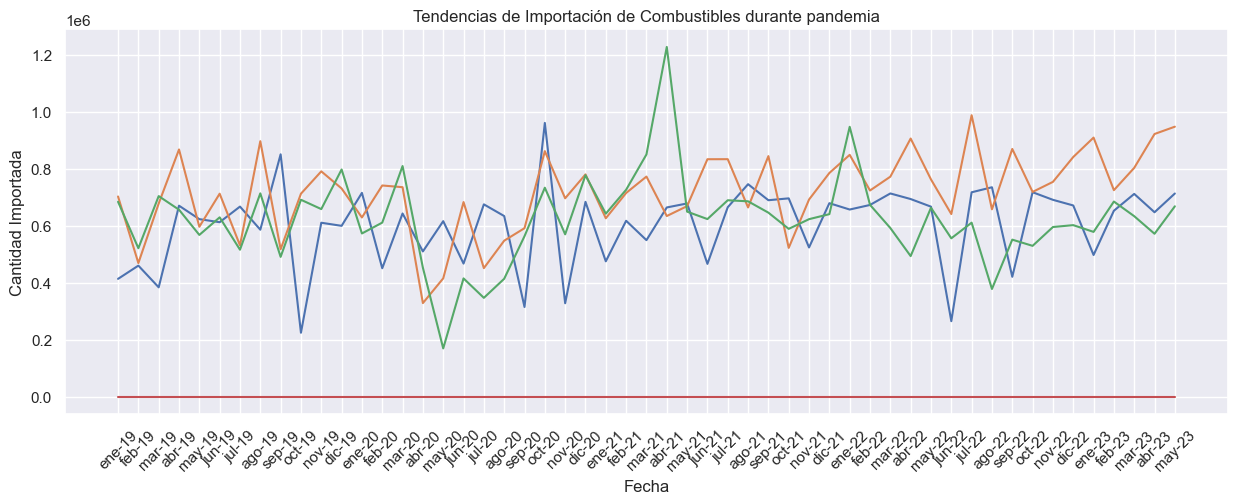

---------------------Consumos---------------------
GAS____________MES
Gas licuado    mar
Regular        dic
Superior       dic
Diesel         mar
dtype: object
GAS____________ANO
Gas licuado    22
Regular        22
Superior       21
Diesel         17
dtype: object


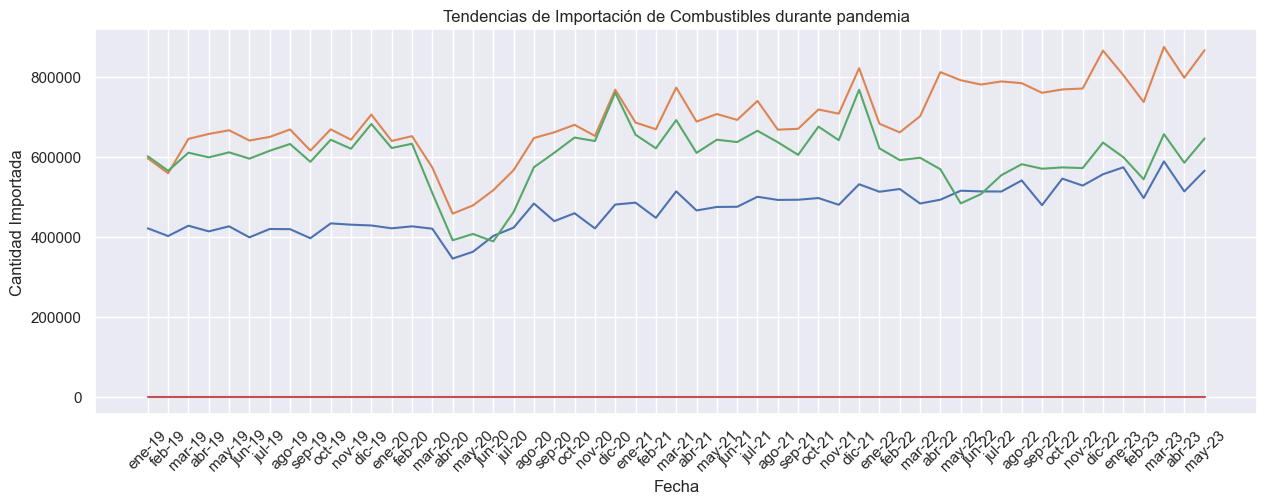

---------------------Precios----------------------
GAS____________MES
Superior    may
Regular     may
Diesel      mar
dtype: object
GAS____________ANO
Superior    2022
Regular     2022
Diesel      2022
dtype: object


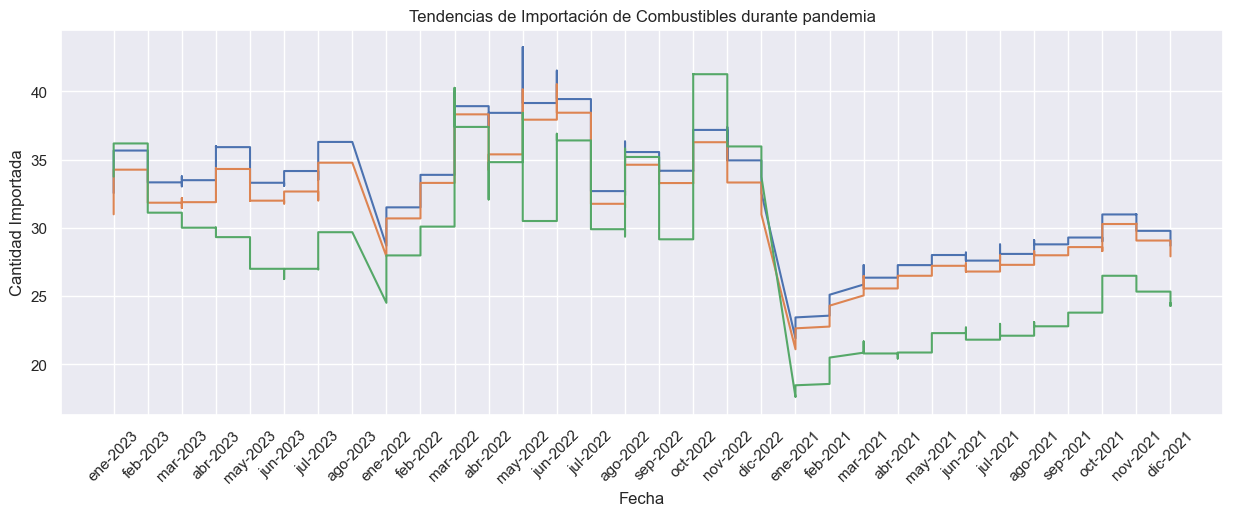

In [88]:
def tendencias(dataframe):
    importes_mensuales = dataframe.groupby('Mes').sum(numeric_only=True).reset_index()
    maximos_x_gas = importes_mensuales.set_index('Mes').idxmax()
    print("GAS____________MES")
    print(maximos_x_gas)

    importes_mensuales = dataframe.groupby('Año').sum(numeric_only=True).reset_index()
    maximos_x_gas = importes_mensuales.set_index('Año').idxmax()
    print("GAS____________ANO")
    print(maximos_x_gas)
       
       
    plt.figure(figsize=(15, 5))
    df_pandemic = dataframe[dataframe['Año'].astype(int) >= 19]
    for column in df_pandemic.select_dtypes(include=['number']).columns:
        plt.plot(df_pandemic['Mes'] + '-' + df_pandemic['Año'], df_pandemic[column], label=column)
    plt.title("Tendencias de Importación de Combustibles durante pandemia")
    plt.xlabel("Fecha")
    plt.ylabel("Cantidad Importada")
    plt.xticks(rotation=45)
    plt.show()

    
for x in dataframes:
    print(x.name.center(50, "-"))
    tendencias(x)

Gas licuado    22
Regular        22
Superior       21
Diesel         16
dtype: object